In [ ]:
using DifferentialEquations
using LinearAlgebra
using SparseArrays
using Symbolics
using Peaks
using CSV
using DataFrames
using JSON
using GLMakie
using StatsBase
using Colors  # This is necessary only if you are using Colors in your plot
using Pkg

# Add MKL support
Pkg.add("MKL")
Pkg.build("MKL")
# Install additional necessary packages
Pkg.add("LaTeXStrings")
Pkg.add("QuadGK")
Pkg.add("Quadrature")
Pkg.add("ProgressMeter")
Pkg.add("Plots")
Pkg.add("Gadfly")

# Inline GLMakie for interactive plotting
Makie.inline!(true)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Ch

true

### Reaction Diffusion in three dimensions

We want to simulate the reaction diffusion according to this following coupled PDE: 
$$
\begin{aligned}
\frac{\partial c_A}{\partial t} &= D_A \nabla^2 c_A - k_{on} c_Ac_B + k_{off}c_{AB} \\
\frac{\partial c_B}{\partial t} &= D_B \nabla^2 c_B - k_{on} c_Ac_B + k_{off}c_{AB} \\ 
\frac{\partial c_{AB}}{\partial t} &= D_{AB} \nabla^2 c_{AB} + k_{on} c_Ac_B - k_{off}c_{AB} 
\end{aligned}
$$

## Set the parameters and simulation space

In [3]:
function radial_laplacian_3d_Neumann(N_r, r_max)
    rd = range(0, stop=r_max, length=N_r)
    dr = step(rd)
    ir_indices = Int[]
    jc_indices = Int[]
    data_values = Float64[]

    for ir in 1:N_r
        r = rd[ir]
        center_idx = ir
        center_val = 0.0
        
        # Neumann boundary condition at r = 0 (ir == 1)
        if ir == 1
            push!(ir_indices, center_idx)
            push!(jc_indices, center_idx)
            push!(data_values, -1/(dr^2))  # Center contribution

            if N_r > 1
                push!(ir_indices, center_idx)
                push!(jc_indices, center_idx + 1)  # Right neighbor
                push!(data_values, 1/(dr^2))  # Contribution from T_1
            end
            
        # Internal points
        elseif ir > 1 && ir < N_r
            if ir > 1  # Left neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, ir - 1)
                push!(data_values, 1/(dr^2) - 1/(dr * r))  # Radial contribution
            end 

            if ir < N_r  # Right neighbor
                push!(ir_indices, center_idx)
                push!(jc_indices, ir + 1)
                push!(data_values, 1/(dr^2) + 1/(dr * r))  # Radial contribution
            end
            
            # Center position contribution for internal points
            center_val -= 2/(dr^2)  # Total contribution from neighbors
            push!(ir_indices, center_idx)
            push!(jc_indices, center_idx)
            push!(data_values, center_val)
        end
        
        # Neumann boundary condition at r = r_max (last point)
        if ir == N_r
            push!(ir_indices, center_idx)
            push!(jc_indices, center_idx)
            push!(data_values, -1/(dr^2))  # Center contribution

            if N_r > 1
                push!(ir_indices, center_idx)
                push!(jc_indices, center_idx - 1)  # Left neighbor
                push!(data_values, 1/(dr^2))  # Contribution from T_{N-1}
            end
        end
    end 
    
    return sparse(ir_indices, jc_indices, data_values, N_r, N_r)
end


radial_laplacian_3d_Neumann (generic function with 1 method)

### intial conditions

In [4]:
function init_concentration_3D_spherical(rgrid, R0, u1_const, u2_const)
    # rgrid is a vector of radial distances
    N_r = length(rgrid)
    # Initialize the concentration field with zeros
    u = zeros(N_r, 3)  # Assuming u has three components (u1, u2, u3)
    for i in 1:N_r
        r = rgrid[i]   
        if r <= R0
            u[i, 1] = u1_const  # Inside R0: u1 is constant, u2 and u3 are 0
            u[i, 2] = 0
            u[i, 3] = 0
        else
            u[i, 1] = 0         # Outside R0: u1 is 0, u2 is constant, u3 is 0
            u[i, 2] = u2_const
            u[i, 3] = 0
        end
    end
    u
end

init_concentration_3D_spherical (generic function with 1 method)

In [ ]:
function init_concentration_3D_spherical_smoothed(rgrid, epsilon, u1_const, u2_const, R0)
    # rgrid is a vector of radial distances
    N_r = length(rgrid)
    # Initialize the concentration field with zeros
    u = zeros(N_r, 3)  # Assuming u has three components (u1, u2, u3)
    for i in 1:N_r
        r = rgrid[i]
        u[i, 1] = u1_const/2 * (1 + tanh((r^2 - R0^2) / epsilon))  # Smooth transition for u1
        u[i, 2] = u2_const/2 * (1 - tanh((r^2 - R0^2) / epsilon))  # Smooth transition for u2
        u[i, 3] = 0  # u3 remains zero
    end
    u
end

init_concentration_3D_spherical_smoothed (generic function with 1 method)

In [81]:
# Define the ODE function for spherical diffusion
function diffuse_spherical_diff(du, u, p, t)
    D, kon, koff = p
    @inbounds du[:, 1] = D * mat_div * u[:, 1] + koff * u[:, 3] - kon * u[:, 1].*u[:, 2]
    @inbounds du[:, 2] = + koff * u[:, 3] - kon * u[:, 1].*u[:, 2]
    @inbounds du[:, 3] = - koff * u[:, 3] + kon * u[:, 1].*u[:, 2]
end

diffuse_spherical_diff (generic function with 1 method)

In [ ]:
# Set parameters
r_limit = 75   # Maximum radial distance
N_r = 7500      # Number of radial grid points

rgrid = range(0, stop=r_limit, length=N_r)
dr = step(rgrid)
mat_div = radial_laplacian_3d_Neumann(N_r, r_limit)

# Define reaction diffusion parameters
D = 40
k_on = 1.6e9
k_off = 24
ps_temp = (D, k_on, k_off)

epsilon = 0.2
R0 = 5
u1_const = 1.328e-8
u2_const = 6.34e-5
# Setup initial concentration vector
u_init = init_concentration_3D_spherical_smoothed(rgrid, epsilon, u1_const, u2_const, R0)

X = u_init
dX = similar(X)

# Define ODEProblem
t_end = 3600
savedt = 10
# Create ODE problem
ode_prob = ODEProblem(
    (du, u, p, t) -> diffuse_spherical_diff(du, u, p, t),
    X,
    (0.0, t_end),
    ps_temp
)

ODEProblem with uType Matrix{Float64} and tType Float64. In-place: true
timespan: (0.0, 3600.0)
u0: 7500×3 Matrix{Float64}:
 0.0       6.34e-5  0.0
 0.0       6.34e-5  0.0
 0.0       6.34e-5  0.0
 0.0       6.34e-5  0.0
 0.0       6.34e-5  0.0
 0.0       6.34e-5  0.0
 0.0       6.34e-5  0.0
 0.0       6.34e-5  0.0
 0.0       6.34e-5  0.0
 0.0       6.34e-5  0.0
 ⋮                  
 1.328e-8  0.0      0.0
 1.328e-8  0.0      0.0
 1.328e-8  0.0      0.0
 1.328e-8  0.0      0.0
 1.328e-8  0.0      0.0
 1.328e-8  0.0      0.0
 1.328e-8  0.0      0.0
 1.328e-8  0.0      0.0
 1.328e-8  0.0      0.0

In [98]:
# Define the solver
solver = Rodas5P()
# Solve the ODE problem
diffuse_spherical_sol = solve(ode_prob, solver, saveat=savedt)
# Check results
println("Simulation completed.")
println(size(diffuse_spherical_sol))  # Should include time dimension

Simulation completed.
(7500, 3, 361)


In [99]:
df = DataFrame(time = diffuse_spherical_sol.t, u=diffuse_spherical_sol.u);
println("Size of mat_div: ", size(mat_div))

Size of mat_div: (7500, 7500)


In [100]:
function extract_data(u_data::Vector{String}, time, indicator)
    # Step 1: Remove the square brackets and split the string by semicolons into rows
    rows = split(strip(u_data[time], ['[', ']']), ";")
    # Step 2: Extract the second column (3rd element in each row) and store as a vector of strings
    second_column = [split(row)[indicator] for row in rows]
    # Step 3: Convert the second column from string to Float64
    numbers = parse.(Float64, second_column)
    # Return the second column as numbers
    return numbers
end

extract_data (generic function with 2 methods)

In [101]:
function extract_data_matrix(u_data::Vector{Matrix{Float64}}, time, indicator)
    # Extract the matrix at the given time index
    matrix_at_time = u_data[time]  
    # Extract the specified column (indicator) as a vector
    numbers = matrix_at_time[:, indicator]
    return numbers
end

extract_data_matrix (generic function with 1 method)

In [102]:
diffuse_spherical_sol.u[361]

7500×3 Matrix{Float64}:
 7.19019e-9  4.28568e-5  2.05432e-5
 7.19019e-9  4.28568e-5  2.05432e-5
 7.19019e-9  4.28568e-5  2.05432e-5
 7.19019e-9  4.28568e-5  2.05432e-5
 7.19019e-9  4.28568e-5  2.05432e-5
 7.19019e-9  4.28568e-5  2.05432e-5
 7.19019e-9  4.28568e-5  2.05432e-5
 7.19019e-9  4.28568e-5  2.05432e-5
 7.19019e-9  4.28568e-5  2.05432e-5
 7.19019e-9  4.28568e-5  2.05432e-5
 ⋮                       
 7.19027e-9  0.0         0.0
 7.19027e-9  0.0         0.0
 7.19027e-9  0.0         0.0
 7.19027e-9  0.0         0.0
 7.19027e-9  0.0         0.0
 7.19027e-9  0.0         0.0
 7.19027e-9  0.0         0.0
 7.19027e-9  0.0         0.0
 7.19027e-9  0.0         0.0

In [106]:
## time points, here 1-t=0; 181-t=1/2h; 361-t=1h
time_points = [1, 61, 121, 181] 
time = diffuse_spherical_sol.t
# Extract profiles at the initial, middle, and last time steps
profile_1 = extract_data_matrix(diffuse_spherical_sol.u, time_points[1], 3) # Initial time step
profile_2 = extract_data_matrix(diffuse_spherical_sol.u, time_points[2], 3) # Middle time step
profile_3 = extract_data_matrix(diffuse_spherical_sol.u, time_points[3], 3) # Middle time step
profile_4 = extract_data_matrix(diffuse_spherical_sol.u, time_points[4], 3) # Middle time step
# take the region of interest for plot, here 10um from the center of the nuclues
region_of_interest = rgrid .<= 10
rgrid_filtered = rgrid[region_of_interest] 

profile_1_filtered = profile_1[region_of_interest]
profile_2_filtered = profile_2[region_of_interest]
profile_3_filtered = profile_3[region_of_interest]
profile_4_filtered = profile_4[region_of_interest]


1000-element Vector{Float64}:
 2.0466587607043755e-5
 2.0466588912646822e-5
 2.0466589565437357e-5
 2.0466590653413336e-5
 2.0466592176564702e-5
 2.0466594134874898e-5
 2.0466596528324574e-5
 2.0466599356888183e-5
 2.0466602620536846e-5
 2.0466606319236585e-5
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

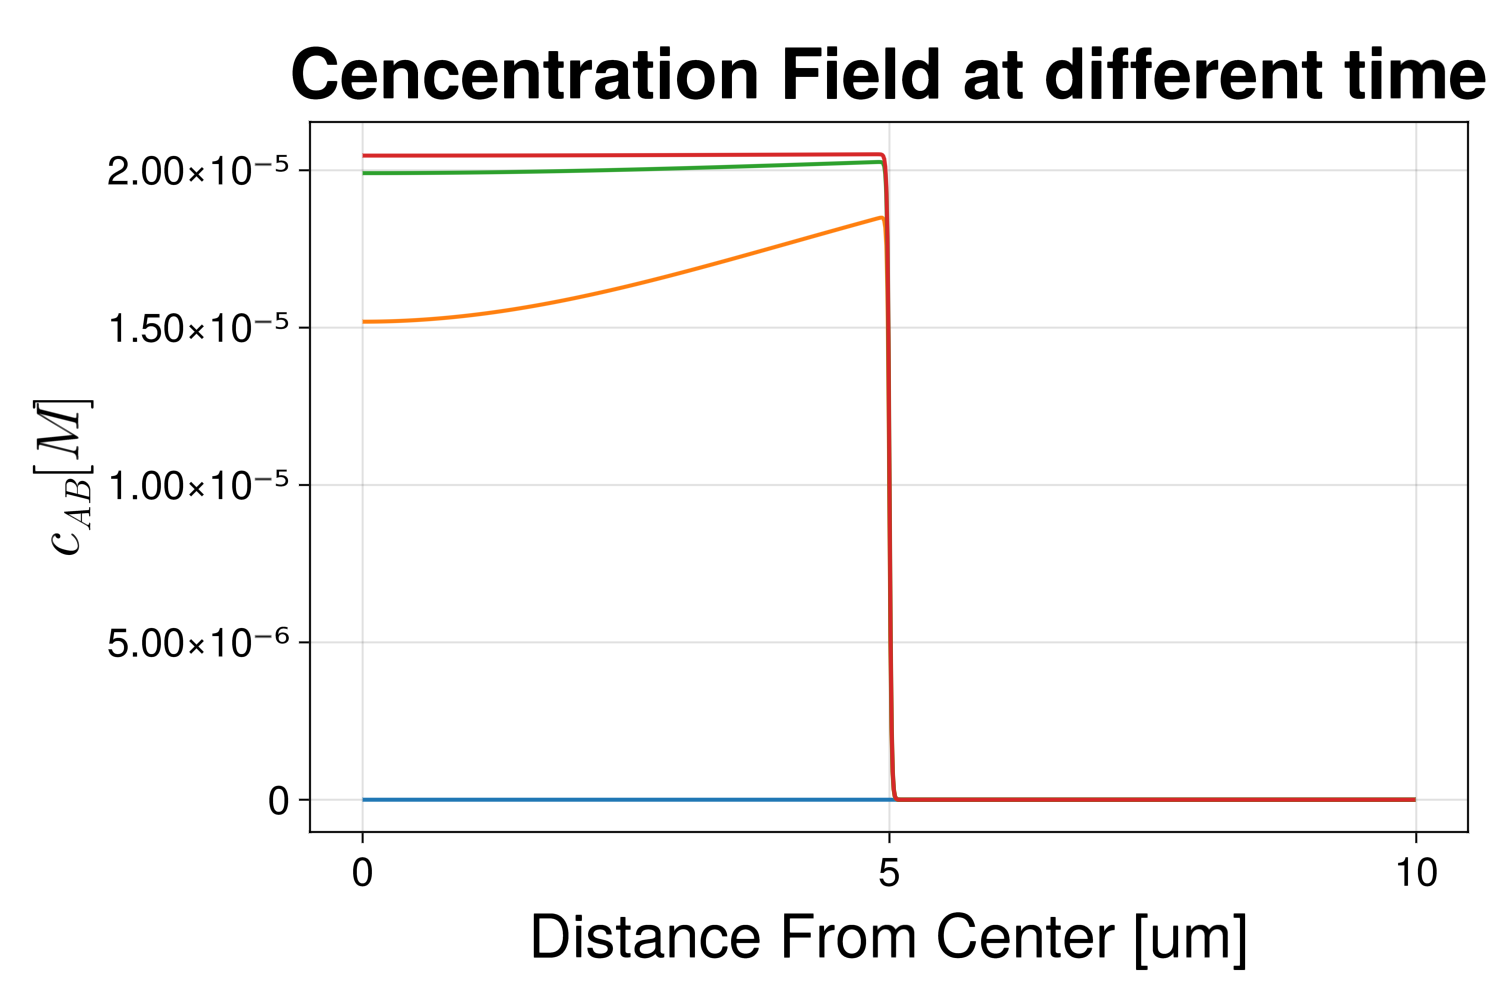

GLMakie.Screen(...)

In [107]:
fig = Figure(size = (750, 500), fontsize = 20)
# Create the axis
ax = Axis(fig[1, 1], title = "Cencentration Field at different time", 
        xlabel = "Distance From Center [um]", 
        ylabel=L"c_{AB} [M]",
        xlabelsize=30, ylabelsize=30, titlesize=35)

# Define the tab10 color palette (these are the colors from Seaborn's tab10)
tab10_colors = [
        RGB(0.121568, 0.466667, 0.705882),  # Blue
        RGB(1.000000, 0.498039, 0.054902),  # Orange
        RGB(0.172549, 0.627451, 0.172549),  # Green
        RGB(0.839216, 0.152941, 0.156863),  # Red
        RGB(0.580392, 0.403922, 0.741176),  # Purple
        RGB(0.549020, 0.337255, 0.294118),  # Brown
        RGB(0.890196, 0.466667, 0.760784),  # Pink
        RGB(0.498039, 0.498039, 0.498039),  # Gray
        RGB(0.737255, 0.741176, 0.133333),  # Olive
        RGB(0.090196, 0.745098, 0.811765)  # Cyan
    ]

# Define the plot using the correct color names from the Colors.jl library
lines!(ax, rgrid_filtered, profile_1_filtered, label = "t=0", color = tab10_colors[1], linewidth = 2)
lines!(ax, rgrid_filtered, profile_2_filtered, label = "t=10 min", color = tab10_colors[2], linewidth = 2)
lines!(ax, rgrid_filtered, profile_3_filtered, label = "t=20 min", color = tab10_colors[3], linewidth = 2)
lines!(ax, rgrid_filtered, profile_4_filtered, label = "t=30 min", color = tab10_colors[4], linewidth = 2)

# Legend(fig[1, 2], ax, label = ["Numerical Initial", "Numerical Middle", "Numerical Last"], position = :topright)
# Display the plot
display(fig)